In [39]:
using Pkg
Pkg.activate("..")

using NCDatasets
using Dates
using CSV, DataFrames
using Statistics
using PyPlot


  Activating project at `~/Projects/cmip6`


In [9]:
omi = CSV.read("./psl_mjoindex/omi.1x.txt", DataFrame, delim=" ", header=0, ignorerepeated=true)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1979,1,1,0,0.16041,0.77522,0.79164
2,1979,1,2,0,0.01581,0.85422,0.85436
3,1979,1,3,0,-0.16171,0.92164,0.93572
4,1979,1,4,0,-0.3654,0.96801,1.03468
5,1979,1,5,0,-0.58519,0.98446,1.14525
6,1979,1,6,0,-0.8081,0.96423,1.25808
7,1979,1,7,0,-1.01951,0.90399,1.36257
8,1979,1,8,0,-1.20495,0.80417,1.44866
9,1979,1,9,0,-1.3519,0.66842,1.50812


In [12]:
omidt = Date.(omi[:,1], omi[:,2], omi[:,3])
omi1 = omi[:,5]
omi2 = omi[:,6]
omiampl = omi[:,6]

16071-element Vector{Float64}:
 0.77522
 0.85422
 0.92164
 0.96801
 0.98446
 0.96423
 0.90399
 0.80417
 0.66842
 0.50241
 ⋮
 1.1515
 1.2675
 1.35404
 1.40111
 1.4003
 1.34591
 1.23585
 1.07224
 0.88723

In [112]:
# ERA5 temperature and specific_humidity
era = NCDataset("ERA5-bl-temperature-easteq.nc")
erat = era[:t][:,:,:,:]
eraq = NCDataset("ERA5-bl-shum-easteq.nc")[:q][:,:,:,:]

# vertical grid
L137_table = CSV.read("L137_table.csv", DataFrame,
    types=[Int64, Float64, Float64, Float64, Union{Missing,Float64}, Union{Missing,Float64}, Float64, Float64, Float64],
    missingstring="-")
galt = zeros(Float64, size(L137_table[119:end,1]))
galt .= L137_table[119:end,"Geometric Altitude [m]"][:]
pres = 0*galt
pres .= L137_table[119:end,"ph [hPa]"]

# blh
blh = NCDataset("ERA5-bl-blh-easteq.nc")
blh[:blh][:,41,1]
blh[:longitude][:]

361-element Vector{Float32}:
  0.0
  0.25
  0.5
  0.75
  1.0
  1.25
  1.5
  1.75
  2.0
  2.25
  ⋮
 88.0
 88.25
 88.5
 88.75
 89.0
 89.25
 89.5
 89.75
 90.0

In [ ]:

theta(t,p) = t * (1e3/p)^0.287
# erath = broadcast(theta, erat, pres)
erath = erat
# map along 3rd dimension, super slow!
for ci in CartesianIndices(erat) 
    erath[ci] = theta(erat[ci],pres[ci[3]])
end

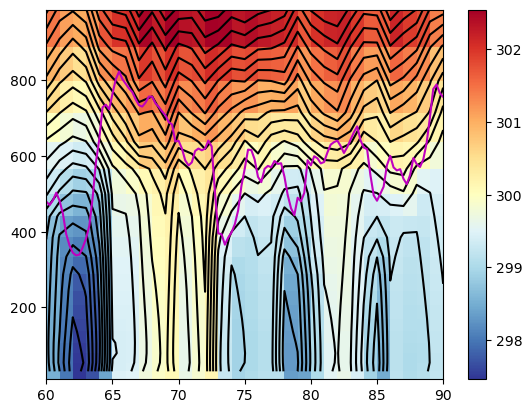

In [119]:
pd = permutedims
anom(x,dims) = x - mean(x,dims)

clf()
pcolormesh(era[:longitude][61:91], galt[1:end], pd(erath[61:90,11,:,1]), 
    shading="flat", cmap=ColorMap("RdYlBu_r"))
colorbar()
contour(era[:longitude][61:91], galt[1:end-1], pd(erath[61:91,11,:,1]), 
    colors="k", linewidth=0.1, levels= 296.8:0.2:303.2)
plot(blh[:longitude][241:end], blh[:blh][241:end,41,1], color="m")
gcf()

In [103]:
era[:latitude][11]

0.0f0